In [29]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [30]:
import torch
from torch import tensor, Tensor, as_tensor, float32, zeros, ones, eye
from sbi.inference import SNPE
import sbibm
from sbi.utils import BoxUniform
from sbi.utils.support_posterior import PosteriorSupport
from sbi.analysis import pairplot
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from copy import deepcopy
from tqdm import tqdm

In [31]:
def coverage(
    posterior,
    theta,
    x,
    used_features,
    num_x: int = 100,
    alpha=torch.linspace(0, 1, 50),
    num_monte_carlo: int = 1_000,
):
    posterior = deepcopy(posterior)
    gt_is_covered = zeros(alpha.shape)
    theta = theta.numpy()
    x = x.numpy()
    x = x[:, used_features]
    nonan = np.invert(np.any(np.isnan(x), axis=1))
    x = x[nonan]
    theta = theta[nonan]
    x = x[:num_x]
    theta = theta[:num_x]
    with tqdm(total=len(theta)) as pbar:
        for params, summstats in tqdm(zip(theta, x)):
            xo = as_tensor(np.asarray([summstats]), dtype=float32)
            posterior.set_default_x(xo)
            lprobs = posterior.log_prob(
                posterior.sample((num_monte_carlo,), show_progress_bars=False)
            )
            gt_log_prob = posterior.log_prob(
                as_tensor(np.asarray([params]), dtype=float32)
            )
            rank_of_gt = compute_rank(gt_log_prob, lprobs)
            norm_rank = rank_of_gt / lprobs.shape[0]
            covered_in_alpha_quantile = norm_rank > alpha
            gt_is_covered += covered_in_alpha_quantile.float()
            pbar.update(1)
    gt_is_covered /= x.shape[0]
    return alpha, torch.flip(gt_is_covered, dims=[0])

def compute_rank(val: Tensor, vec: Tensor):
    c = torch.cat([vec, val])
    s = torch.argsort(c)
    ind = torch.where(s == len(c) - 1)
    return ind[0]  # .where returns a tuple

def plot_coverage(alpha, gt_is_covered):
    fig, ax = plt.subplots(1, 1, figsize=(1.5, 1.5))
    ax.plot([0, 1.0], [0, 1.0], c="grey")
    ax.plot(alpha, gt_is_covered)
    ax.set_xticks([0, 1])
    ax.set_yticks([0, 1])
    ax.set_xlim([0, 1])
    ax.set_ylim([0, 1])
    ax.set_xlabel("Confidence level")
    ax.set_ylabel("Empirical coverage")


In [32]:
task = sbibm.get_task("two_moons")  # See sbibm.get_available_tasks() for all tasks
prior = task.get_prior()
simulator = task.get_simulator()
observation = task.get_observation(num_observation=1)  # 10 per task
reference_samples = task.get_reference_posterior_samples(num_observation=1)
# These objects can then be used for custom inference algorithms, e.g.
# we might want to generate simulations by sampling from prior:
_ = torch.manual_seed(0)
theta = prior(num_samples=10000)
x = simulator(theta)

In [15]:
_ = torch.manual_seed(0)
inference = SNPE(density_estimator="nsf")
_ = inference.append_simulations(theta, x).train(max_num_epochs=2000, training_batch_size=10000)

 Neural network successfully converged after 773 epochs.

In [100]:
ind = 1
observation = task.get_observation(num_observation=ind)  # 10 per task
reference_samples = task.get_reference_posterior_samples(num_observation=ind)

posterior1 = inference.build_posterior().set_default_x(observation)
proposal1 = PosteriorSupport(task.get_prior_dist(), posterior1, num_samples_to_estimate_support=100000, allowed_false_negatives=0.0001)

Drawing 100000 posterior samples:   0%|          | 0/100000 [00:00<?, ?it/s]

In [101]:
posterior_samples1 = posterior1.sample((10000,))
support_samples = proposal1.sample((1000,))

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

The classifier rejected 66.0200% of all samples. You will get a speed-up of 194.3%.


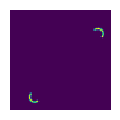

In [102]:
h, _, _ = np.histogram2d(reference_samples[:, 0].numpy(), reference_samples[:, 1].numpy(), bins=75, range=[[-1, 1], [-1, 1]])

with mpl.rc_context(fname="../../.matplotlibrc"):
    fig, ax = plt.subplots(1, 1, figsize=(1.3, 1.3))
    ax.imshow(h, extent=[-1, 1, -1, 1], origin="lower")
    ax.set_xticks([])
    ax.set_yticks([])
    ax.spines["bottom"].set_visible(False)
    ax.spines["left"].set_visible(False)
    plt.savefig("../svg/panel_a.svg")

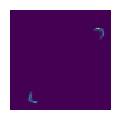

In [103]:
h1, _, _ = np.histogram2d(posterior_samples1[:, 0].numpy(), posterior_samples1[:, 1].numpy(), bins=75, range=[[-1, 1], [-1, 1]])

with mpl.rc_context(fname="../../.matplotlibrc"):
    fig, ax = plt.subplots(1, 1, figsize=(1.3, 1.3))
    ax.imshow(h1, extent=[-1, 1, -1, 1], origin="lower")
    ax.set_xticks([])
    ax.set_yticks([])
    ax.spines["bottom"].set_visible(False)
    ax.spines["left"].set_visible(False)
    plt.savefig("../svg/panel_b1.svg")

In [104]:
x = torch.linspace(-1, 1, 100)
X, Y = torch.meshgrid(x, x)
xy = torch.stack([X, Y])
xy = torch.reshape(xy, (2, 100**2)).T

In [105]:
support_probs = proposal1.predict(xy)
support_probs = torch.reshape(support_probs, (100, 100))

In [106]:
reference_samples = task.get_reference_posterior_samples(num_observation=ind)

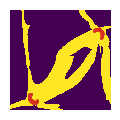

In [107]:
with mpl.rc_context(fname="../../.matplotlibrc"):
    fig, ax = plt.subplots(1, 1, figsize=(1.3, 1.3))
    ax.imshow(support_probs.numpy(), extent=[-1, 1, -1, 1], origin="lower")
    ax.scatter(reference_samples[:100, 1].numpy(), reference_samples[:100, 0].numpy(), s=1, c="#d7301f")
    ax.set_xticks([])
    ax.set_yticks([])
    ax.spines["bottom"].set_visible(False)
    ax.spines["left"].set_visible(False)
    plt.savefig("../svg/panel_b2.svg")

In [108]:
pred = proposal1.predict(reference_samples)

In [109]:
print("Fraction of accepted", (torch.sum(pred)/reference_samples.shape[0]).item()*100, "%")

Fraction of accepted 100.0 %


In [24]:
theta = prior(num_samples=100)
x = simulator(theta)
alpha, gt_is_covered = coverage(posterior1, theta, x, [0, 1])

 95%|█████████████████████████████████████████████████████████████████████████████████████████████     | 95/100 [00:01<00:00, 65.83it/s]
100it [00:01, 67.66it/s][A
100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 67.57it/s]


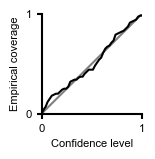

In [25]:
with mpl.rc_context(fname="../../.matplotlibrc"):
    fig, ax = plt.subplots(1, 1, figsize=(1.3, 1.3))
    ax.plot([0, 1.0], [0, 1.0], c="grey")
    ax.plot(alpha, gt_is_covered, c="k")
    ax.set_xticks([0, 1])
    ax.set_yticks([0, 1])
    ax.set_xlim([0, 1])
    ax.set_ylim([0, 1])
    ax.set_xlabel("Confidence level")
    ax.set_ylabel("Empirical coverage")
    plt.savefig("../svg/panel_c.svg")

In [26]:
prior_ = task.get_prior_dist()

In [270]:
_ = torch.manual_seed(0)
inference = SNPE(density_estimator="nsf")
proposal = prior_
for _ in range(10):
    theta = proposal.sample((1000,))
    x = simulator(theta)

    _ = inference.append_simulations(theta, x).train(max_num_epochs=2000, training_batch_size=10000, force_first_round_loss=True)
    posterior = inference.build_posterior().set_default_x(observation)
    proposal = PosteriorSupport(task.get_prior_dist(), posterior, num_samples_to_estimate_support=100000, allowed_false_negatives=0.0001)

 Neural network successfully converged after 225 epochs.

Drawing 100000 posterior samples:   0%|          | 0/100000 [00:00<?, ?it/s]

The classifier rejected 42.1000% of all samples. You will get a speed-up of 72.7%.
 Neural network successfully converged after 173 epochs.

Drawing 100000 posterior samples:   0%|          | 0/100000 [00:00<?, ?it/s]

The classifier rejected 59.6300% of all samples. You will get a speed-up of 147.7%.
 Neural network successfully converged after 295 epochs.

Drawing 100000 posterior samples:   0%|          | 0/100000 [00:00<?, ?it/s]

The classifier rejected 74.9000% of all samples. You will get a speed-up of 298.4%.
 Neural network successfully converged after 64 epochs.

Drawing 100000 posterior samples:   0%|          | 0/100000 [00:00<?, ?it/s]

The classifier rejected 77.5900% of all samples. You will get a speed-up of 346.2%.
 Neural network successfully converged after 64 epochs.

Drawing 100000 posterior samples:   0%|          | 0/100000 [00:00<?, ?it/s]

The classifier rejected 81.3500% of all samples. You will get a speed-up of 436.2%.
 Neural network successfully converged after 82 epochs.

Drawing 100000 posterior samples:   0%|          | 0/100000 [00:00<?, ?it/s]

The classifier rejected 76.7000% of all samples. You will get a speed-up of 329.2%.
 Neural network successfully converged after 108 epochs.

Drawing 100000 posterior samples:   0%|          | 0/100000 [00:00<?, ?it/s]

The classifier rejected 80.6400% of all samples. You will get a speed-up of 416.5%.
 Neural network successfully converged after 75 epochs.

Drawing 100000 posterior samples:   0%|          | 0/100000 [00:00<?, ?it/s]

The classifier rejected 77.6700% of all samples. You will get a speed-up of 347.8%.
 Neural network successfully converged after 69 epochs.

Drawing 100000 posterior samples:   0%|          | 0/100000 [00:00<?, ?it/s]

The classifier rejected 79.2900% of all samples. You will get a speed-up of 382.9%.
 Neural network successfully converged after 84 epochs.

Drawing 100000 posterior samples:   0%|          | 0/100000 [00:00<?, ?it/s]

In [271]:
posterior_samples = posterior.sample((10000,))

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

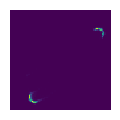

In [345]:
h, _, _ = np.histogram2d(posterior_samples[:, 0].numpy(), posterior_samples[:, 1].numpy(), bins=75, range=[[-1, 1], [-1, 1]])

with mpl.rc_context(fname="../../.matplotlibrc"):
    fig, ax = plt.subplots(1, 1, figsize=(1.3, 1.3))
    ax.imshow(h, extent=[-1, 1, -1, 1], origin="lower")
    ax.set_xticks([])
    ax.set_yticks([])
    ax.spines["bottom"].set_visible(False)
    ax.spines["left"].set_visible(False)
    plt.savefig("../svg/panel_d.svg")

In [110]:
import time
import IPython.display as IPd

def svg(img):
    IPd.display(IPd.HTML('<img src="{}" / >'.format(img, time.time())))

In [170]:
from svgutils.compose import *

# > Inkscape pixel is 1/90 of an inch, other software usually uses 1/72.
# > http://www.inkscapeforum.com/viewtopic.php?f=6&t=5964
svg_scale = 1.25  # set this to 1.25 for Inkscape, 1.0 otherwise

# Panel letters in Helvetica Neue, 12pt, Medium
kwargs_text = {'size': '12pt', 'font': 'Arial', 'weight': '800'}
kwargs_consistent = {'size': '10pt', 'font': 'Arial', 'weight': '500', 'color': '#AF99EF'}
kwargs_consistent1 = {'size': '10pt', 'font': 'Arial', 'weight': '500', 'color': '#9E7DD5'}
kwargs_inconsistent = {'size': '10pt', 'font': 'Arial', 'weight': '500', 'color': '#AF99EF'}
kwargs_text8pt = {'size': '7.7pt', 'font': 'Arial'}

f = Figure("15.7cm", "4.0cm",
           
    Panel(
          SVG("../svg/panel_a.svg").scale(svg_scale).move(0, 0),
          Text("True posterior", 23, -6.0, **kwargs_text8pt),
          Text("a", 5, -6.0, **kwargs_text),
    ).move(-5, 20),
    Panel(
          SVG("../svg/panel_b1.svg").scale(svg_scale).move(0, 0),
          Text("b", 5, -6.0, **kwargs_text),
          Text("Approx. posterior Round 1", 50, -6.0, **kwargs_text8pt),
          Text("Density", 40, 5.0, **kwargs_text8pt),
    ).move(115, 20),
    Panel(
          SVG("../svg/panel_b2.svg").scale(svg_scale).move(0, 0),
          Text("Support", 40, 5.0, **kwargs_text8pt),
    ).move(215, 20),
    Panel(
          SVG("../svg/panel_c.svg").scale(svg_scale).move(0, 0),
          Text("c", 3, -1.0, **kwargs_text),
    ).move(335, 16),
    Panel(
          SVG("../svg/panel_d.svg").scale(svg_scale).move(0, 0),
          Text("Approx. posterior", 13, -6.0, **kwargs_text8pt),
        Text("Round 10", 30, 5.0, **kwargs_text8pt),
          Text("d", -5, -6.0, **kwargs_text),
    ).move(492, 20),
)

f.save("../fig/fig3.svg")
svg('../fig/fig3.svg')